# Sprint 8.1 - Visualizaciones en Python

Esta práctica permitirá explorar cómo se pueden utilizar herramientas de visualización avanzadas en Python para interpretar y presentar datos de forma efectiva, proporcionando una oportunidad valiosa para mejorar las habilidades analíticas y técnicas.


## Nivel 1

#### Realiza la conexión en Python con MySQL Workbench para cargar toda la información que tienes en las tablas.


In [ ]:
# Para realizar la conección entre Python y MySQL, y también poder utilizar las herramientas de visualizacion, primero instalaremos los paquetes necesarios.
!pip install mysql-connector-python
!pip install numpy
!pip install scipy
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Para obtener las tablas de nuestra base de datos en MySQL y trabajar con ellas como dataframes en Python, realizaremos los siguientes pasos:

1. Realizaremos la conexión entre MySQL y Python con el paquete mysql.connector, proveyendole la autentificación necesaria.    
2. Definiremos una lista de las tablas presentes en la base de datos, y abriremos un diccionario para almacenar los dataframes.    
3. Gracias a la conexión establecida podremos abrir un cursor, y mediante un bucle y una consulta SQL extraeremos toda la información de las tablas, almacenandola como dataframes en un diccionario.    
4. Cerramos tanto el cursor como la conexión establecida y renombramos los dataframes para extraerlos del diccionario.    
5. Finalmente usaremos el método df.info() para dar un vistazo a la estructura de nuestros dataframes y transformar las columnas que los necesiten, como por ejemplo las columnas que en nuestra base de datos contienen fechas y valores decimales.

In [2]:
db_connection = mysql.connector.connect(
    host='localhost', 
    user='root', 
    password='root', 
    database='db_transactions')

MySQL_tables = ['company', 'credit_card', 'credit_card_state', 'product', 'transaction', 'transaction_products', 'user']
cursor = db_connection.cursor()

for table in MySQL_tables:
    cursor.execute(f"SELECT * FROM {table}")
    columns = [col[0] for col in cursor.description]
    globals()[f"df_{table}"] = pd.DataFrame(cursor.fetchall(), columns=columns)
    # print(f'df_{table}')    # Para ver los dataframes resultantes.
    # globals()[f"df_{table}"].info()    # Uso el método df.info() para saber si habría que hacer alguna transformación de datos.

cursor.close()
db_connection.close()

df_credit_card['expiring_date'] = pd.to_datetime(df_credit_card['expiring_date'])
df_product['price'] = df_product['price'].astype(float)
df_product['weight'] = df_product['weight'].astype(float)
df_transaction['amount'] = df_transaction['amount'].astype(float)
df_transaction['declined'] = df_transaction['declined'].astype(bool)
df_user['birth_date'] = pd.to_datetime(df_user['birth_date'])

# Para usar en Power BI, transaformaremos estas columnas a string y remplazaremos los puntos (.) por comas (,).
# df_product['price'] = df_product['price'].astype(str).str.replace('.', ',', regex=False)
# df_product['weight'] = df_product['weight'].astype(str).str.replace('.', ',', regex=False)
# df_transaction['amount'] = df_transaction['amount'].astype(str).str.replace('.', ',', regex=False)

#### Aquí agruparé los merge que serán necesarios luego en las gráficas.

In [3]:
# Ejercicio 2:
df_user['age'] = (pd.to_datetime('today') - df_user['birth_date']).dt.days // 365
df_user['age_group'] = pd.cut(df_user['age'], bins=[22, 30, 38, 45], labels=['23 to 30', '31 to 38', '39 to 45'], right=True)
df_user_transaction = pd.merge(df_user, df_transaction, left_on='id', right_on='user_id', how='outer')
df_amount_by_age = df_user_transaction.groupby('age_group')['amount'].sum().reset_index()

# Ejercicio 3:
df_count_of_companies = df_company.groupby('country').size().sort_values(ascending=False).reset_index()
df_count_of_companies = df_count_of_companies.merge(df_company, left_on='country', right_on='country', how='left')

# Ejercicio 4:
df_company_transactions = pd.merge(df_company, df_transaction, left_on='id', right_on='company_id', how='outer')
df_sum_of_amount = df_company_transactions.groupby('country')['amount'].sum().reset_index().sort_values(by='amount', ascending=True)

# Ejercicio 5:
# df_company_transactions = pd.merge(df_company, df_transaction, left_on='id', right_on='company_id', how='outer')
df_declined = df_company_transactions.groupby('country')['id_y'].size().reset_index(name='count')
df_declined = pd.merge(df_declined, df_company_transactions, left_on='country', right_on='country', how='outer')
df_declined = df_declined.sort_values(by='count', ascending=False).reset_index()

# Ejercicio 6:
# df_company_transactions = pd.merge(df_company, df_transaction, left_on='id', right_on='company_id', how='outer')
df_country_summary = df_company_transactions.groupby('country').agg(average=('amount', 'mean'),total_amount=('amount', 'sum')).sort_values(by='total_amount', ascending=False).reset_index()

# Ejercicio 7:
df_product_transaction_products = pd.merge(df_product, df_transaction_products, left_on='id', right_on='product_id', how='outer')
df_product_count = df_product_transaction_products.groupby(['id', 'price']).size().reset_index(name='times_sold')


C:\Users\formacio\AppData\Local\Temp\ipykernel_14236\3246416870.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_amount_by_age = df_user_transaction.groupby('age_group')['amount'].sum().reset_index()


#### Realizarás una visualización para cada ejercicio. Comenta lo que llama la atención de graficar esta variable, justifica la elección del gráfico e interpreta los resultados en función de tus datos.

### Ejercicio 1: Una variable numérica.

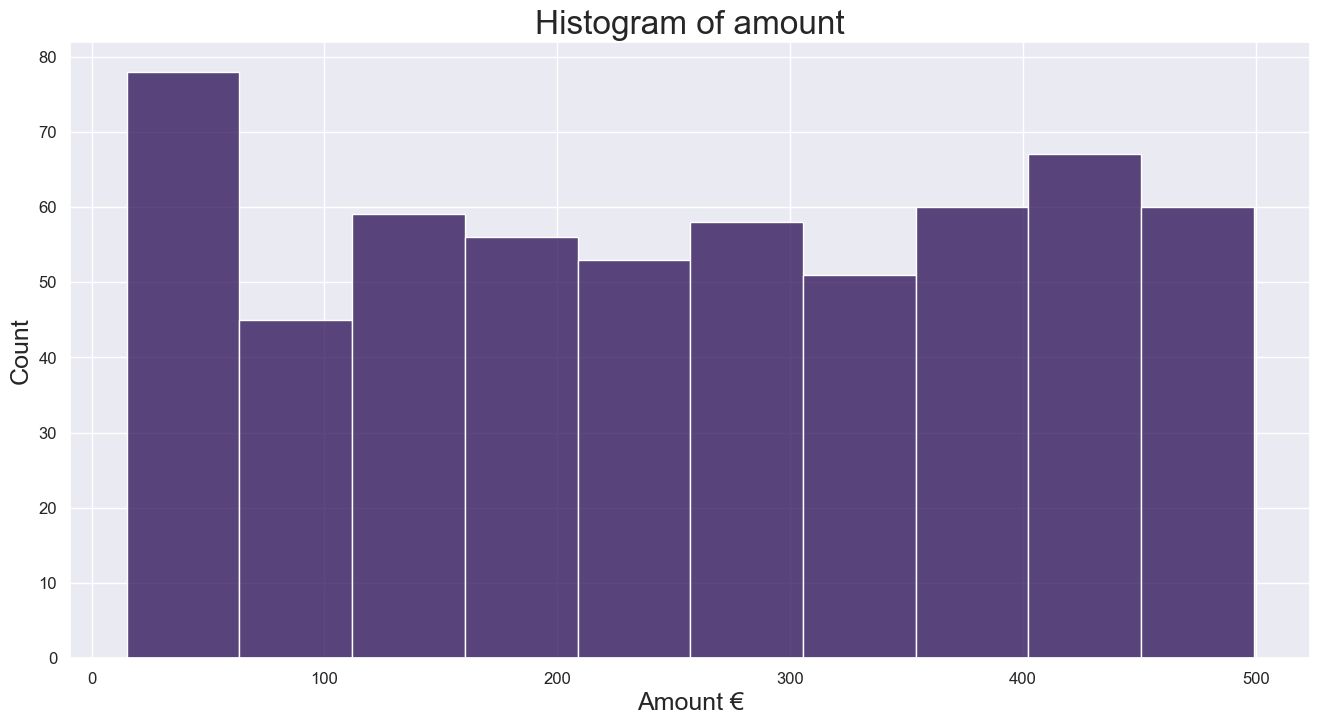

In [4]:
plt.figure(figsize=(16, 8))
sns.set_theme(style='darkgrid', palette='inferno')
ax = sns.histplot(df_transaction['amount'], bins=10)
plt.title('Histogram of amount', size=24)
plt.xlabel('Amount €',size=18)
plt.ylabel('Count', size=18)
plt.tick_params(axis='both', labelsize=12)
plt.show()

#### Análisis de la visualización:

Como podemos apreciar en el histograma, el mayor conteo de compras se dió en el tramo de 0 a 50 euros con aproximadamente 78 transacciones regristradas, y el segundo tramo con mayor conteo es el de 400 a 450 euros, con aproximadamente 66 transacciones. Encontrandose los demás tramos con un conteo muy similar entre si mismos, ocilando entre las 60 y 50 transacciones registradas. Esto nos podría indicar que los usuarios suelen decidir lo que compran por parámetros distintos al precio total resultante de la compra, por ello habría que ahondar más en otros factores que podrían describir de forma más precisa los patrones de compras de nuestros usuarios, y no ver únicamente esta variable numérica de forma aislada, de esa manera obtendremos valiosos insides que nos permitiran trazar una plan de acción.

### Ejercicio 2: Dos variables numéricas.

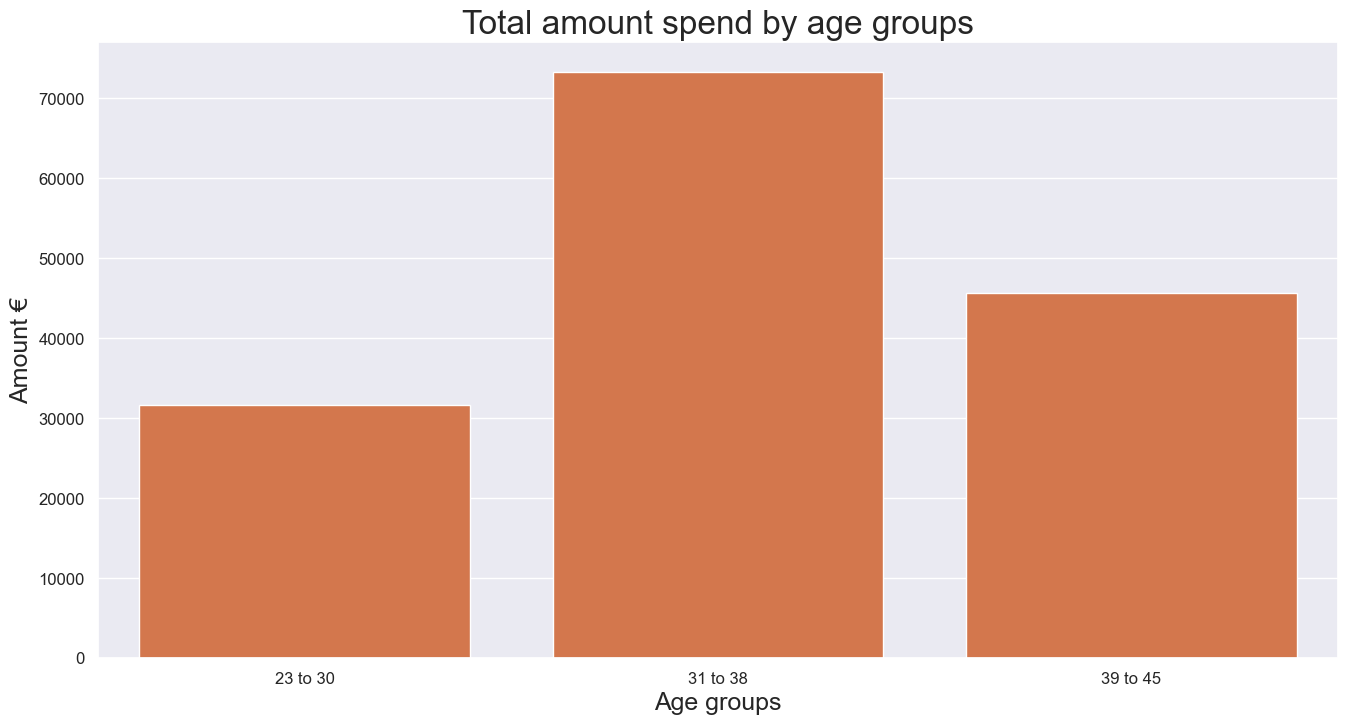

In [5]:
plt.figure(figsize=(16, 8))
sns.set_theme(style='darkgrid', palette='icefire_r')
ax = sns.barplot(data=df_amount_by_age,
                 x='age_group', y='amount')
plt.title('Total amount spend by age groups', size=24)
plt.xlabel('Age groups', size=18)
plt.ylabel('Amount €', size=18)
plt.tick_params(axis='both', labelsize=12)
plt.show()

#### Análisis de la visualización:

La visualización nos muestra claramente, que el grupo que ha gastado más en nuestra compañia es el de 31 a 38 años, siendo el segundo más numeroso el de 39 a 45 años. Ahora que reconocemos estos grupos de usuarios que representan el mayor beneficio para nuestra empresa, podremos enfocar nuestros esfuerzos en ellos y eso nos facilitará el obtener mayores beneficios por un menor esfuerzo.

### Ejercicio 3: Una variable categórica.

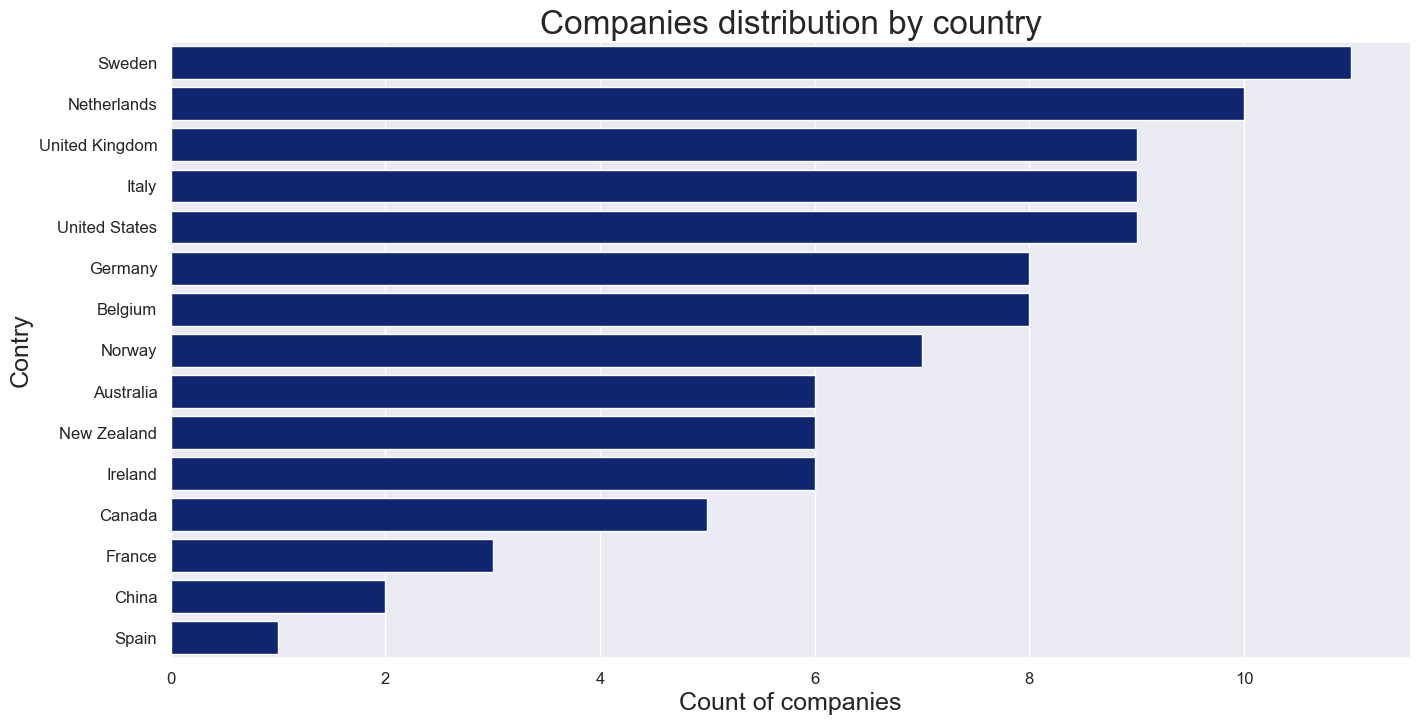

In [18]:
plt.figure(figsize=(16, 8))
sns.set_theme(style='darkgrid', palette='dark')
ax = sns.countplot(data=df_count_of_companies, y='country')
plt.title("Companies distribution by country", size=24)
plt.xlabel('Count of companies', size=18)
plt.ylabel('Contry', size=18)
plt.tick_params(axis='both', labelsize=12)
plt.show()

#### Análisis de la visualización:

Apreciamos que, el top 5 de países con mayor cantidad de compañias son: Suecia con 11 compañias, Holanda con 10, Reino Unido, Italia y Estados Unidos con 9 compañias cada uno. Con esta información esperaríamos que el top de países con más empresas fueran los que nos generan mayores ingresos. Y dado que la gran mayoria de países se encuentran en Europa, podríamos crear campañas de marketing personalizadas a esta región, buscando así maximizar nuestros beneficios en este territorio.

### Ejercicio 4: Una variable categórica y una numérica.

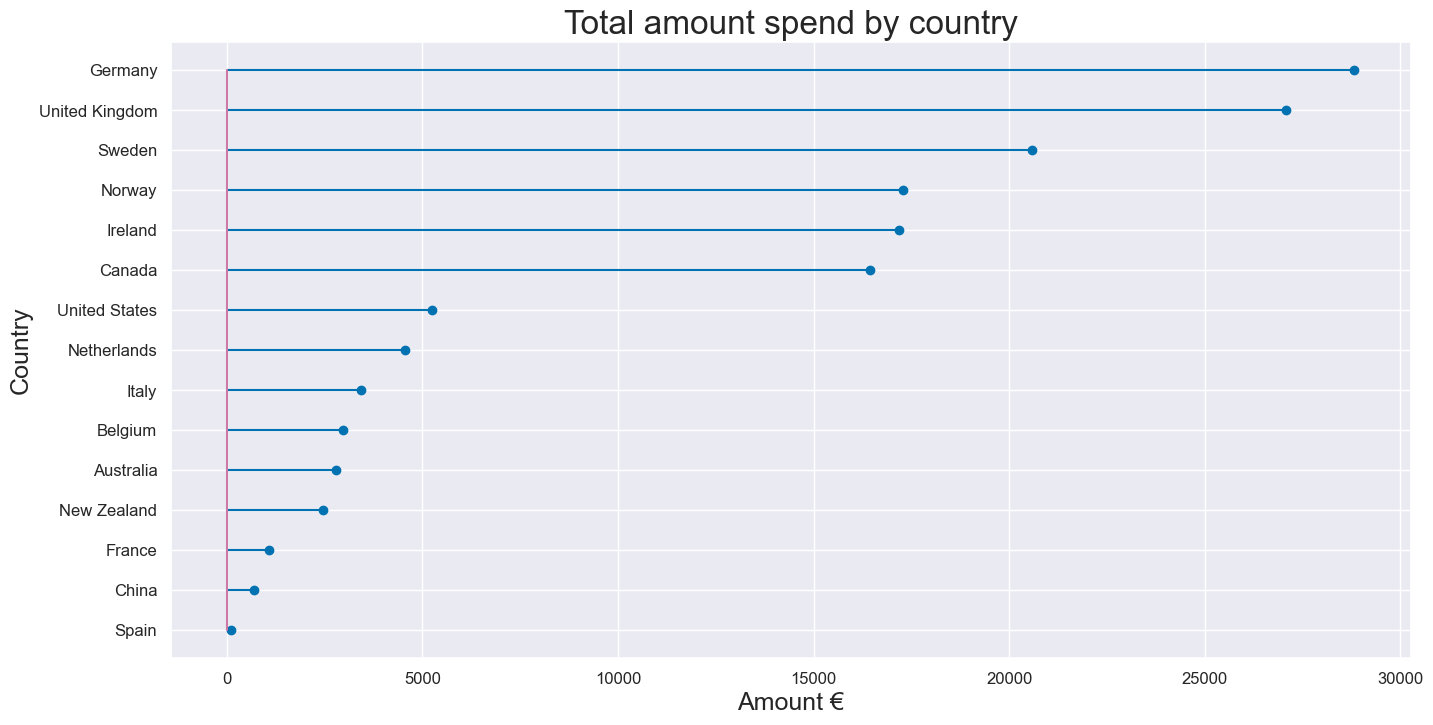

In [7]:
plt.figure(figsize=(16, 8))
plt.style.use('seaborn-v0_8-colorblind')
ax = plt.stem(df_sum_of_amount['country'], df_sum_of_amount['amount'], orientation='horizontal')
plt.title('Total amount spend by country', size=24)
plt.xlabel('Amount €', size=18)
plt.ylabel('Country', size=18)
plt.tick_params(axis='both', labelsize=12)
plt.show()

#### Análisis de la visualización:

Aquí, podemos ver la sumatoria total de ventas por país, el top 5 es: Alemania, Reino Unido, Suecia, Noruega e Irlanda. A primera vista podemos apreciar que tanto Reino Unido como Suecia se encuentran en esté top de países con mayores ventas, lo cuál es esperable porque cuentan una gran cantidad de empresas ubicadas en su territorio. A su vez aparecen países como Alemania, Noruega e Irlanda, que aunque no tienen pocas empresas en su territorio generan un gran beneficio con sus ventas. Y una de las cosas más llamativas es que paises como Estados Unidos, Holanda e Italia, que están en top de paises con más compañias, en su conjunto apenas llegan a producir poco más de la mitad de lo que Alemania produce por si misma.

### Ejercicio 5: Dos variables categóricas.

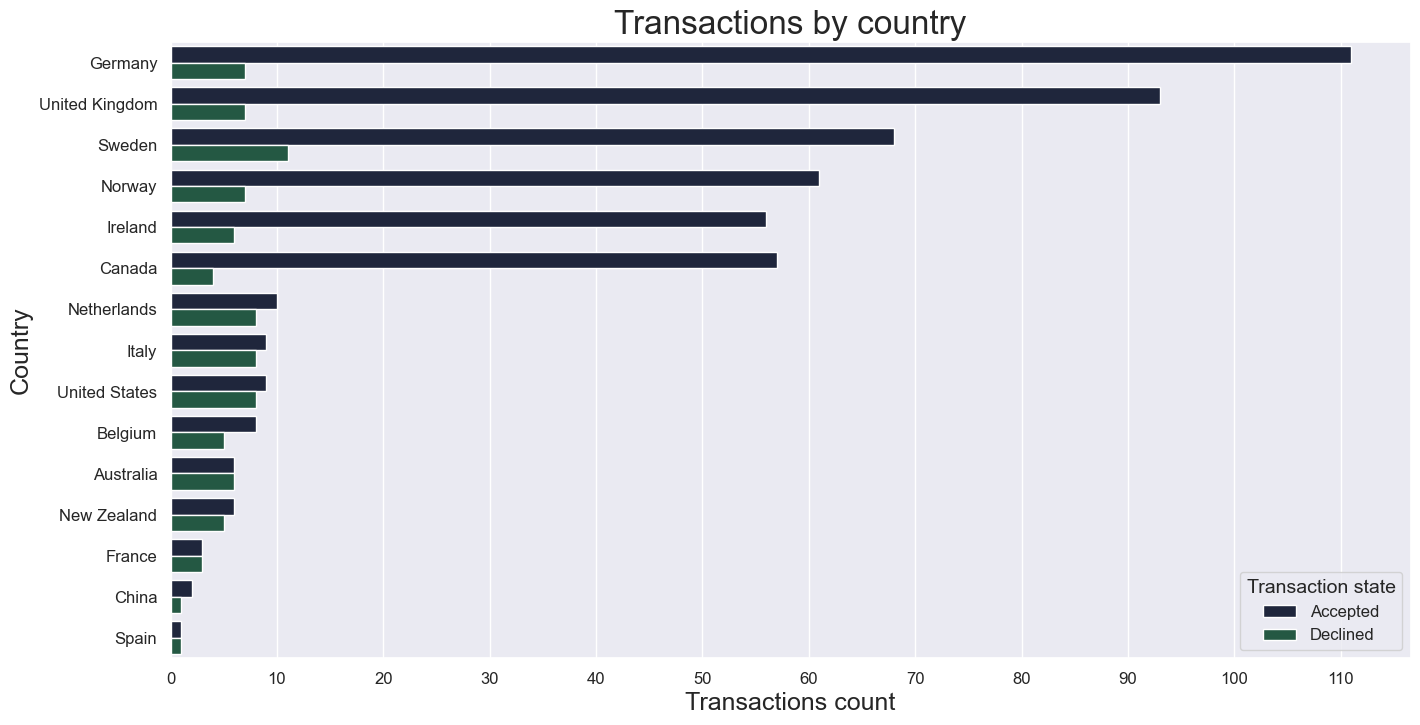

In [17]:
plt.figure(figsize=(16, 8))
sns.set_theme(style='darkgrid', palette='cubehelix')
ax = sns.countplot(data=df_declined,
                   y='country', hue='declined')
ax.legend(title='Transaction state', labels=['Accepted', 'Declined'], fontsize=12, title_fontsize=14)
plt.title('Transactions by country', size=24)
plt.xlabel('Transactions count', size=18)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
plt.ylabel('Country', size=18)
plt.tick_params(axis='both', labelsize=12)
plt.show()

#### Análisis de la visualización:

Ahora, vemos en conteo de transaciones por país, tanto las aceptadas como las rechazadas. En el top 5 de países con más transacciones resgistradas se encuentra: Alemania, Reino Unido, Suecia, Noruega e Irlanda, justamente el mismo top 5 que vimos con anterioridad, estos países se comportan como esperaríamos, presentando una gran cantidad de transacciones aceptadas y pocas transacciones rechazadas. Pero, también podemos ver algo bastante preocupante y es que, Holanda, Italia y Estados Unidos no solo presentan pocas transaciones aceptadas, con menos de 10 cada uno, sino que a su vez presentan practicamente la misma cantidad de transacciones rechazadas es una casi a la par de la otra. Por otro lado, Australia, Francia y España presentan la misma cantidad de transacciones aceptadas y rechazadas. En este punto habría que analizar a mayor profundidad que está causando tan poco rendimiento en estos países, y plantearnos si es algo que podría solucionarse o si por otro lado sería más rentable separarnos de ellos y enfocar todos nuestros esfuerzos en los países que verdaderamente nos están generando beneficios.

### Ejercicio 6: Tres variables.

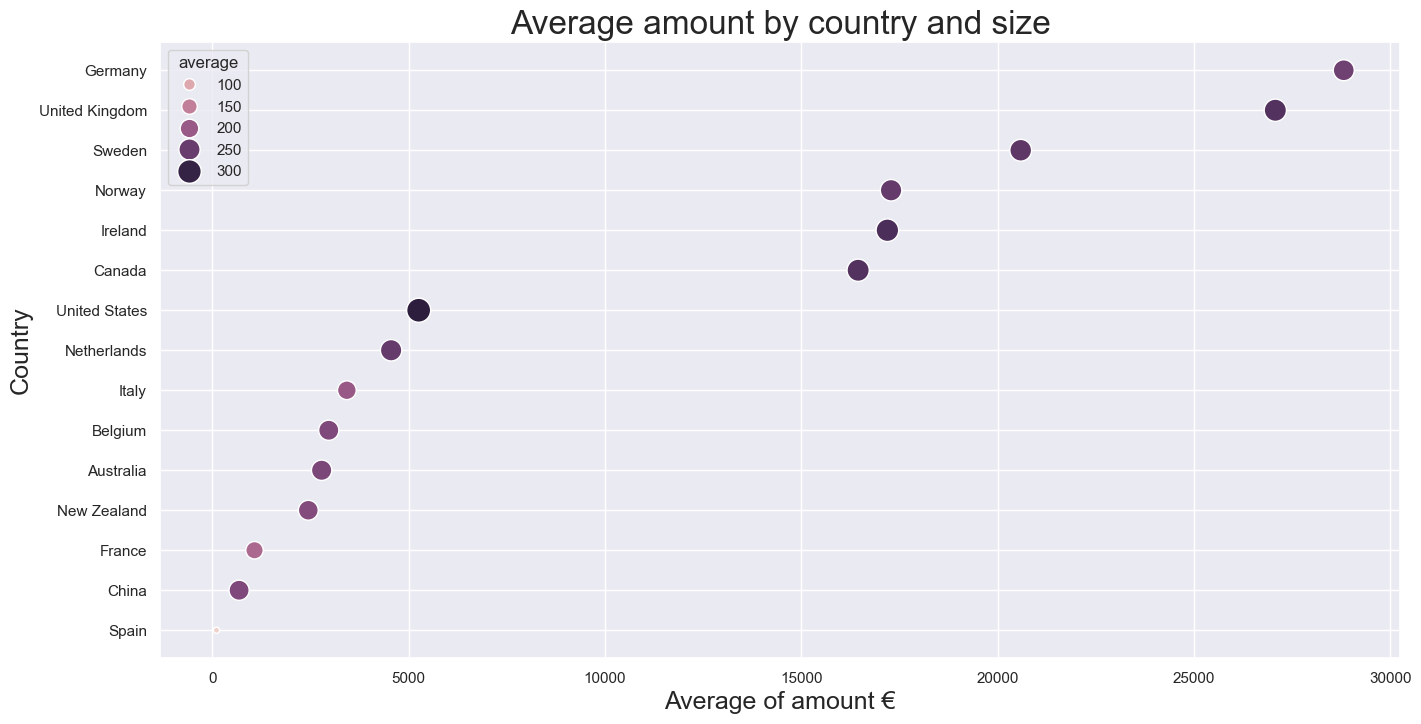

In [14]:
plt.figure(figsize=(16, 8))
sns.set_theme(style='darkgrid', palette='twilight_r')
ax = sns.scatterplot(data=df_country_summary, x='total_amount', y='country', hue='average', size='average', sizes=(20,300))
plt.title('Average amount by country and size', size=24)
plt.xlabel('Average of amount €', size=18)
plt.ylabel('Country', size=18)
plt.show()

#### Análisis de la visualización:



### Ejercicio 7: Graficar un Pairplot.

<Figure size 1600x800 with 0 Axes>

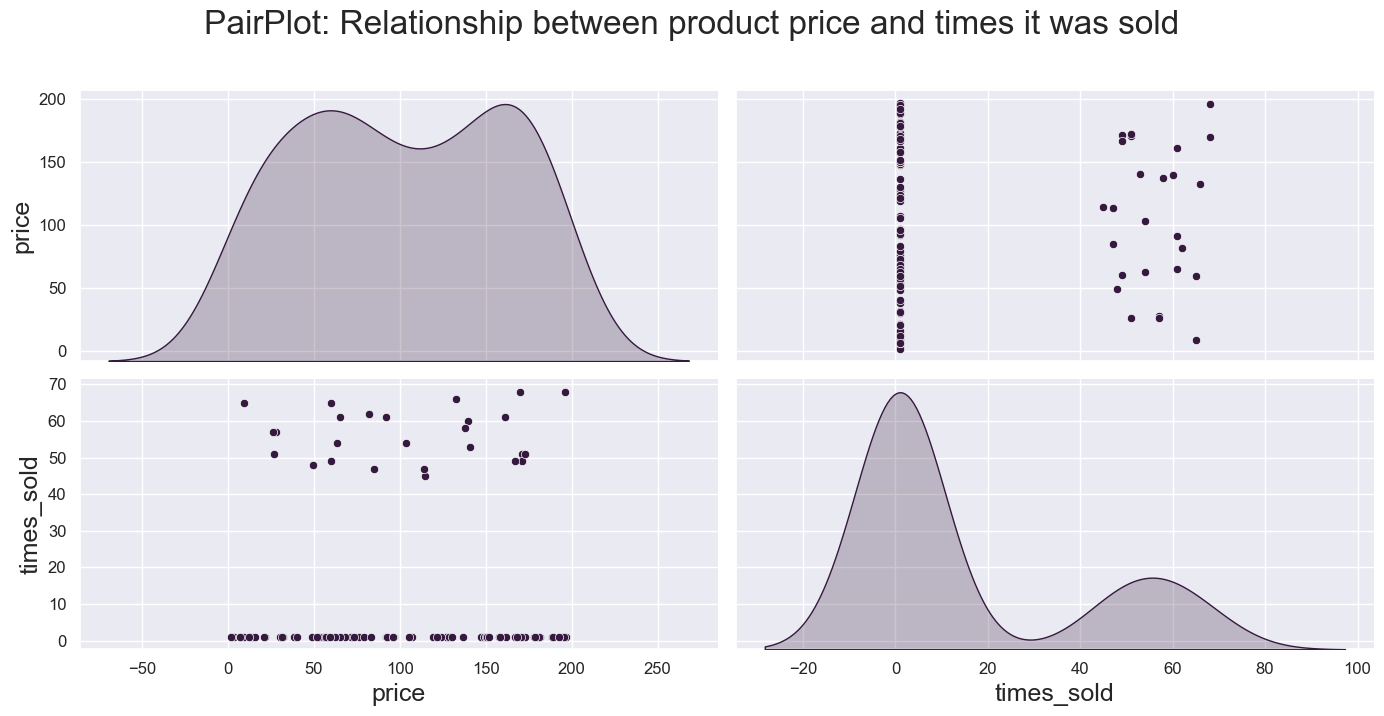

In [16]:
# Idea: ver cuales son los productos que más se rechazan, junto con los productos que más se venden.

plt.figure(figsize=(16, 8), layout="constrained")
sns.set_theme(style='darkgrid', palette='rocket')
ax = sns.pairplot(df_product_count, vars=['price', 'times_sold'], diag_kind='kde', height=3.5, aspect=2)
plt.suptitle('PairPlot: Relationship between product price and times it was sold', size=24, y=1.02)
for x in ax.axes.flatten():
    x.set_xlabel(x.get_xlabel(), fontsize=18)
    x.set_ylabel(x.get_ylabel(), fontsize=18)
    x.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

#### Análisis de la visualización:

Como podemos apreciar en el PairPlot hay 2 grupos bastantes marcados dentro de los datos:    
- El primero, que son los productos que no fueron vendidos ni una sola vez, tienen un conteo de 1 al lado del zero, y representan la grán mayoria de nuestros productos.   
- El segundo, son los podructos que si fueron vendidos, cada uno de estos se vendió más de 40 veces y se vendieron independientemente de su precio porque se extienden a lo largo del ScatterPlot sin mostrar un patrón que pueda relacionar el valor del producto con la cantidad de veces que fue vendido.